In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
merged_features = pd.read_csv('merged_data.csv', header = None)
norm_data = pd.read_csv('merged_norm.csv', header = None)

C:\Users\guido\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (1,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,25

In [2]:
# some numbers are stored as strings, this converts them to numbers
def str_to_float(L):
    return [float(ele) for ele in L]

def str_to_int(L):
    return [int(ele) for ele in L]

In [3]:
# extract target values
genres = np.asarray(norm_data[0:][3])

# convert genres to numbers for kNN
dict_genres = {'Hip-Hop': 0, 'Pop': 1, 'Folk': 2, 'Experimental': 3, 'Rock':4, 'International':5, 'Electronic':6, 'Instrumental':7}
genres = np.asarray([dict_genres[genre] for genre in genres])
num_features = len(genres)

# extract normalized features and convert them as an array of numbers
all_features = np.asarray(norm_data)
str_features = all_features[:, 4:]
features = np.asarray([str_to_float(feature) for feature in str_features])

# do the same for the unnormalized features
regular_str_features = np.asarray(merged_features)[1:, 4:]
reg_features = np.asarray([str_to_float(feature) for feature in regular_str_features])

In [4]:
from sklearn.decomposition import PCA
# from sklearn.decomposition import IncrementalPCA as IPCA

print(features.shape)
print(reg_features.shape)
def perform_PCA(n_comp, features):
    df = pd.DataFrame(features)
    df['label'] = genres

    # perform PCA
    pca = PCA(n_components = n_comp)
    pca_features = pca.fit_transform(df.iloc[:, :-1])
    
    return pca_features

pca_features = perform_PCA(100, features)
pca_reg_features = perform_PCA(100, reg_features)

(7989, 516)
(7989, 519)


In [5]:
from sklearn.model_selection import train_test_split


def split(features):
    # split into training and test
    feat_training, feat_test, genre_training, genre_test = train_test_split(features, genres, test_size=0.1)

    # split into training and validation
    feat_train_sm, feat_val, genre_train_sm, genre_val  = train_test_split(feat_training, genre_training, test_size = 0.1)
    
    return feat_training, feat_test, genre_training, genre_test, feat_train_sm, feat_val, genre_train_sm, genre_val


feat_training, feat_test, genre_training, genre_test, feat_train_sm, feat_val, genre_train_sm, genre_val = split(features)
pca_feat_training, pca_feat_test, pca_genre_training, pca_genre_test, pca_feat_train_sm, pca_feat_val, pca_genre_train_sm, pca_genre_val = split(pca_features)

reg_feat_training, reg_feat_test, reg_genre_training, reg_genre_test, reg_feat_train_sm, reg_feat_val, reg_genre_train_sm, reg_genre_val = split(features)
reg_pca_feat_training, reg_pca_feat_test, reg_pca_genre_training, reg_pca_genre_test, reg_pca_feat_train_sm, reg_pca_feat_val, reg_pca_genre_train_sm, reg_pca_genre_val = split(pca_features)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neighbors import LSHForest
from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.model_selection import cross_val_score

MIN_k = 1
MAX_k = 40

def k_neighbours(x_train, x_test, y_train, y_test, k, weights = False):
    if weights == False:
        knn = KNeighborsClassifier(k)
    else: 
        knn = KNeighborsClassifier(k, weights = 'distance')
        
    knn.fit(x_train, y_train)
    y_predicted = knn.predict(x_test)
    acc = accuracy_score(y_test, y_predicted)
    conf_mat = confusion_matrix(y_test, y_predicted)
    return (acc, conf_mat)

def train(feat_train_sm, feat_val, genre_train_sm, genre_val, weighted = False):
    return [k_neighbours(feat_train_sm, feat_val, genre_train_sm, genre_val, i, weights = weighted) for i in range(MIN_k, MAX_k + 1)], [k for k in range(MIN_k, MAX_k + 1)]

accuracy_noPCA, k = train(feat_training, feat_test, genre_training, genre_test)
accuracy_PCA, k = train(pca_feat_training, pca_feat_test, pca_genre_training, pca_genre_test)
accuracy_weight_noPCA, k = train(feat_training, feat_test, genre_training, genre_test, weighted = True)
accuracy__weight_PCA, k = train(pca_feat_training, pca_feat_test, pca_genre_training, pca_genre_test, weighted = True)


Accuracy score noPCA= 0.3579474342928661
Accuracy score PCA = 0.3967459324155194
Accuracy score weigthed noPCA = 0.3667083854818523
Accuracy score PCA weighted = 0.4142678347934919


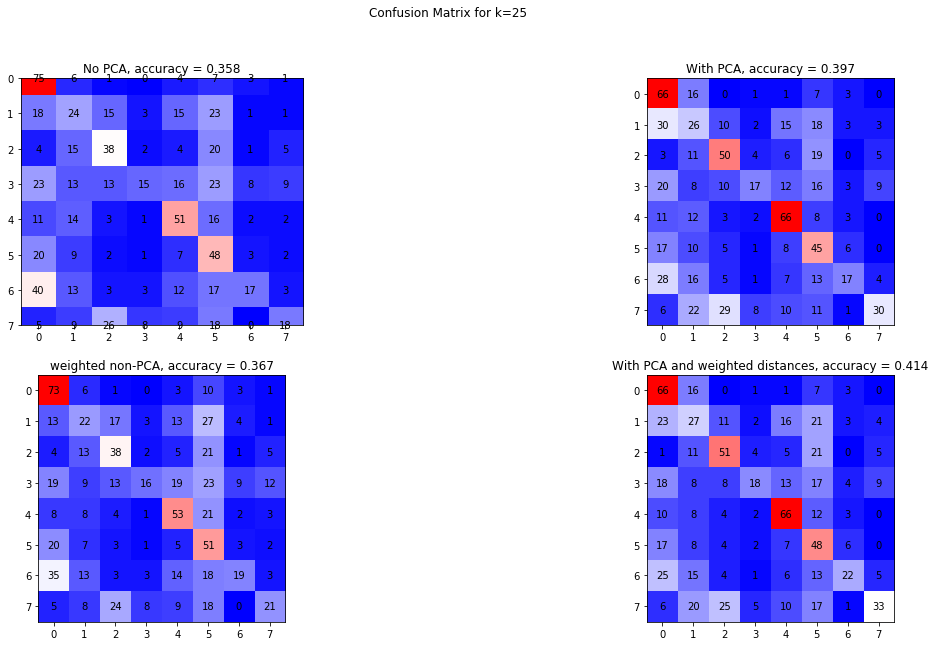

In [18]:
acc, conf_mat = k_neighbours(feat_training, feat_test, genre_training, genre_test, 25)
acc_PCA, conf_mat_PCA = k_neighbours(pca_feat_training, pca_feat_test, pca_genre_training, pca_genre_test, 25)
acc_weight, conf_mat_weight = k_neighbours(feat_training, feat_test, genre_training, genre_test, 25, weights=True)
acc_PCA_weight, conf_mat_PCA_weight = k_neighbours(pca_feat_training, pca_feat_test, pca_genre_training, pca_genre_test, 25, weights=True)

print(f'Accuracy score noPCA= {acc}')
print(f'Accuracy score PCA = {acc_PCA}')
print(f'Accuracy score weigthed noPCA = {acc_weight}')
print(f'Accuracy score PCA weighted = {acc_PCA_weight}')
fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2,figsize=(20,10))
fig.suptitle(f'Confusion Matrix for k=25')
ax1.imshow(conf_mat, interpolation='nearest',cmap = 'bwr')
ax1.set_xticks([0,1,2,3,4,5,6,7])
ax1.set_yticks([0,1,2,3,4,5,6,7])
ax2.imshow(conf_mat_PCA, interpolation='nearest',cmap = 'bwr')
ax3.imshow(conf_mat_weight, interpolation='nearest',cmap = 'bwr')
ax4.imshow(conf_mat_PCA_weight, interpolation='nearest',cmap = 'bwr')
ax1.set_title(f'No PCA, accuracy = {round(acc,3)}')
ax2.set_title(f'With PCA, accuracy = {round(acc_PCA,3)}')
ax3.set_title(f'weighted non-PCA, accuracy = {round(acc_weight,3)}')
ax4.set_title(f'With PCA and weighted distances, accuracy = {round(acc_PCA_weight,3)}')
for (j,i),label in np.ndenumerate(conf_mat):
    ax1.text(i,j,label,ha='center',va='center', color = 'black')
for (j,i),label in np.ndenumerate(conf_mat_PCA):
    ax2.text(i,j,label,ha='center',va='center', color = 'black')
for (j,i),label in np.ndenumerate(conf_mat_weight):
    ax3.text(i,j,label,ha='center',va='center', color = 'black')
for (j,i),label in np.ndenumerate(conf_mat_PCA_weight):
    ax4.text(i,j,label,ha='center',va='center', color = 'black')
# fig.colorbar(plt.cm.ScalarMappable(norm=[100,0], cmap='bwr'))
plt.show()

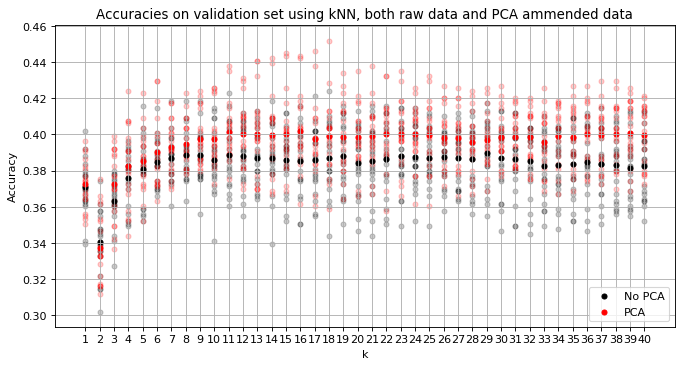

In [8]:
# train for all values of k for multiple times

N_k_test = 20
k_test_data = {}
k_test_data_PCA = {}
k = []

def avg(r):
    return sum(r)/len(r)

for n in range(N_k_test):
    # perform PCA
    pca_features = perform_PCA(100, features)
    
    # split data
    feat_training, feat_test, genre_training, genre_test, feat_train_sm, feat_val, genre_train_sm, genre_val = split(features)
    pca_feat_training, pca_feat_test, pca_genre_training, pca_genre_test, pca_feat_train_sm, pca_feat_val, pca_genre_train_sm, pca_genre_val = split(pca_features)
    
    # perform tests
    acc, k = train(feat_train_sm, feat_val, genre_train_sm, genre_val)
    acc_PCA, k = train(pca_feat_train_sm, pca_feat_val, pca_genre_train_sm, pca_genre_val)
    
    # take add results to all data
    k_test_data[n+1] = acc
    k_test_data_PCA[n+1] = acc_PCA
    

# calculate averages
calc_avgs = {}
calc_avgs_PCA = {}
for ana in range(40):
    calc_avgs[ana+1] = []
    calc_avgs_PCA[ana+1] = []
    
for d in k_test_data:
    ip = 1
    g = k_test_data[d]
    for t in g:
        calc_avgs[ip] += [t[0]]
        ip += 1
        
for d in k_test_data_PCA:
    ip = 1
    g = k_test_data_PCA[d]
    for t in g:
        calc_avgs_PCA[ip] += [t[0]]
        ip += 1

# print(calc_avgs)
        
        

# plot results
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.grid()
for sc in k_test_data:
    acc_to_plot = [i[0] for i in k_test_data[sc]]
    plt.scatter(k, acc_to_plot, alpha = 0.2, s = 20, color = 'black')
for sc_PCA in k_test_data_PCA:
    acc_to_plot = [i[0] for i in k_test_data_PCA[sc_PCA]]
    plt.scatter(k, acc_to_plot, alpha = 0.2, s = 20, color = 'red')
avgs = [avg(calc_avgs[i]) for i in calc_avgs]
# for i in calc_avgs_PCA:
#     print(i)
avgs_PCA = [avg(calc_avgs_PCA[i]) for i in calc_avgs_PCA]
plt.scatter(k, avgs, alpha = 1, s = 20, color = 'black', label='No PCA')
plt.scatter(k, avgs_PCA, alpha = 1, s = 20, color = 'red', label='PCA')
plt.xticks(k)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracies on validation set using kNN, both raw data and PCA ammended data')
plt.legend(loc='lower right')
plt.show()

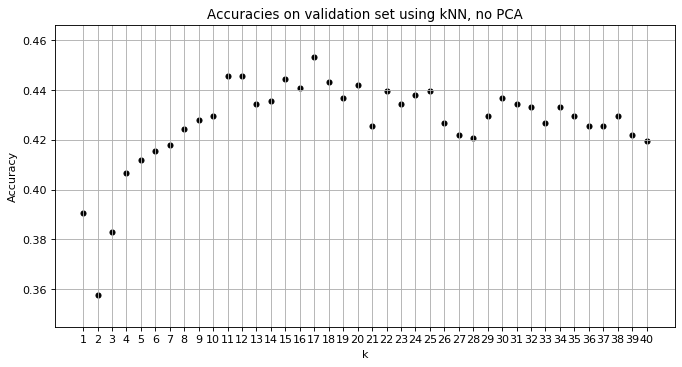

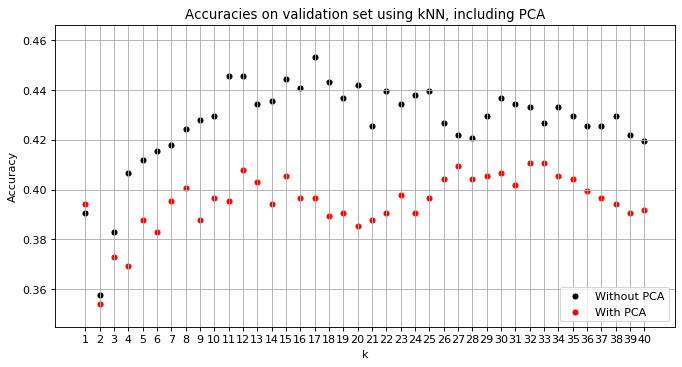

Accuracy score noPCA= 0.3904881101376721
Accuracy score PCA = 0.39424280350438046


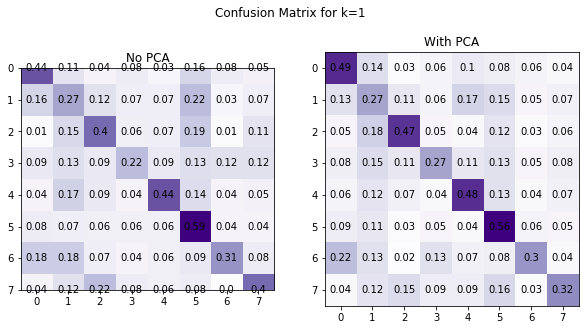

Accuracy score noPCA= 0.3579474342928661
Accuracy score PCA = 0.3541927409261577


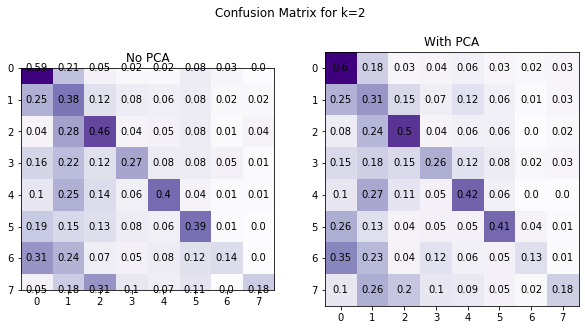

Accuracy score noPCA= 0.3829787234042553
Accuracy score PCA = 0.37296620775969963


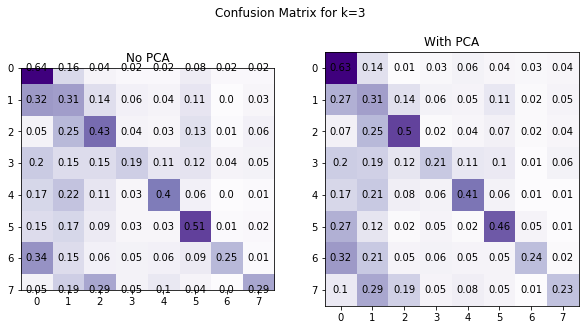

Accuracy score noPCA= 0.4067584480600751
Accuracy score PCA = 0.3692115143929912


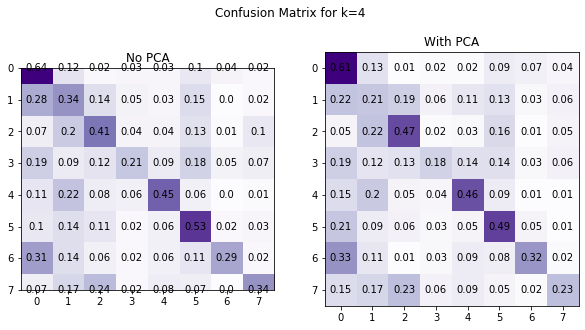

Accuracy score noPCA= 0.4117647058823529
Accuracy score PCA = 0.3879849812265332


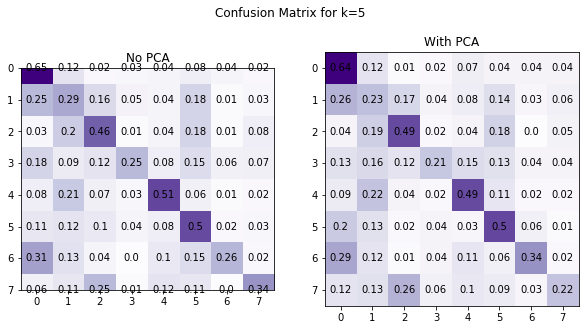

Accuracy score noPCA= 0.41551939924906134
Accuracy score PCA = 0.3829787234042553


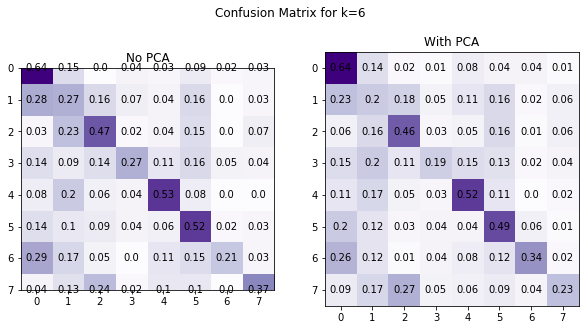

Accuracy score noPCA= 0.41802252816020025
Accuracy score PCA = 0.3954943679599499


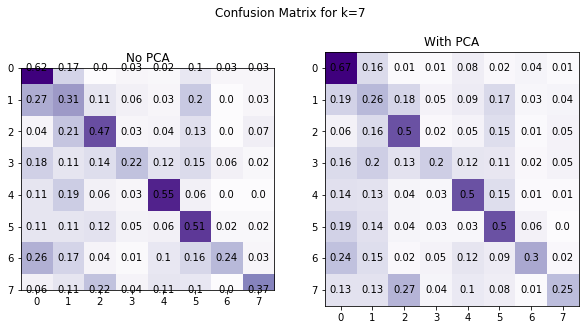

Accuracy score noPCA= 0.42428035043804757
Accuracy score PCA = 0.4005006257822278


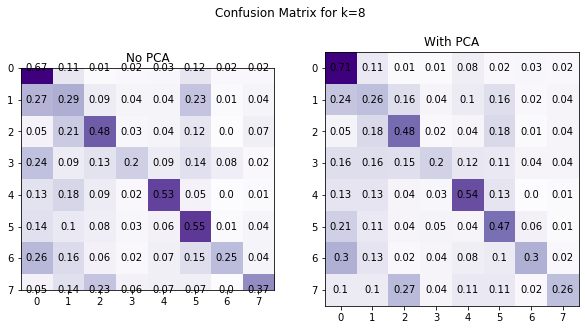

Accuracy score noPCA= 0.42803504380475593
Accuracy score PCA = 0.3879849812265332


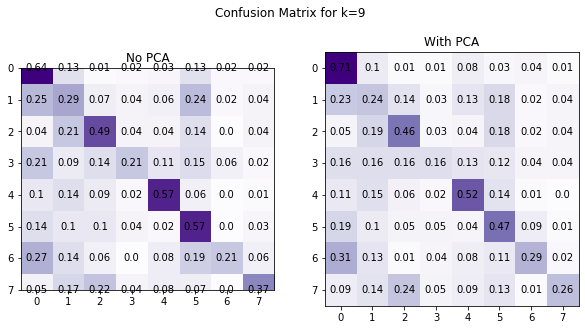

Accuracy score noPCA= 0.4292866082603254
Accuracy score PCA = 0.3967459324155194


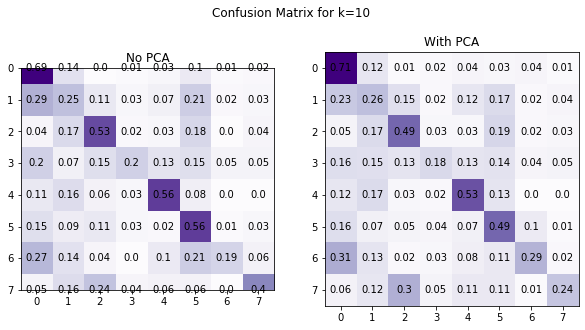

Accuracy score noPCA= 0.4455569461827284
Accuracy score PCA = 0.3954943679599499


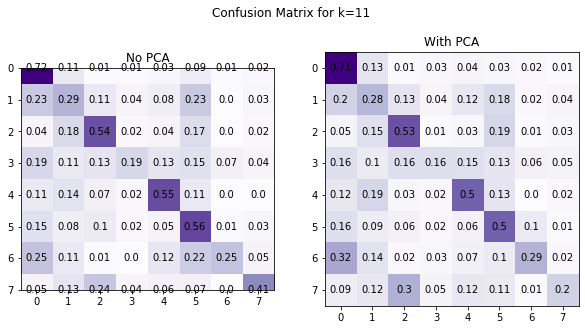

Accuracy score noPCA= 0.4455569461827284
Accuracy score PCA = 0.40801001251564456


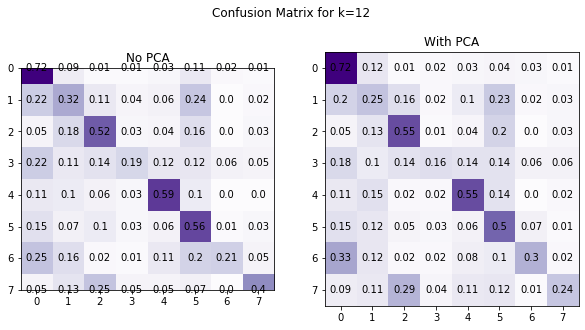

Accuracy score noPCA= 0.43429286608260326
Accuracy score PCA = 0.4030037546933667


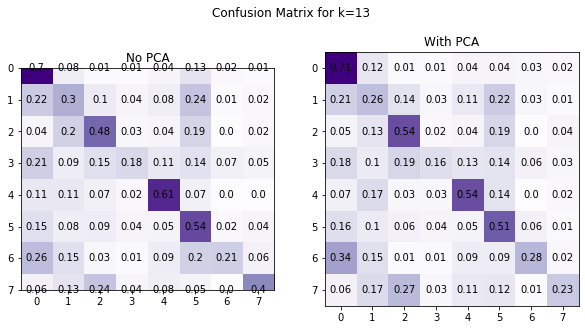

Accuracy score noPCA= 0.4355444305381727
Accuracy score PCA = 0.39424280350438046


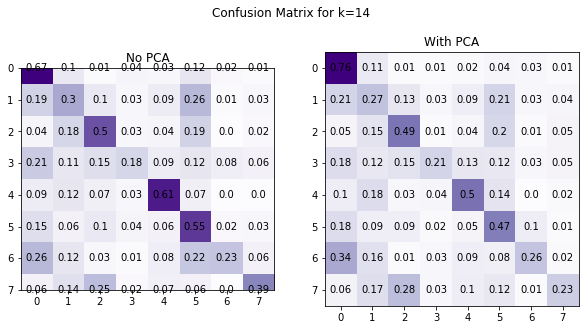

Accuracy score noPCA= 0.44430538172715894
Accuracy score PCA = 0.40550688360450565


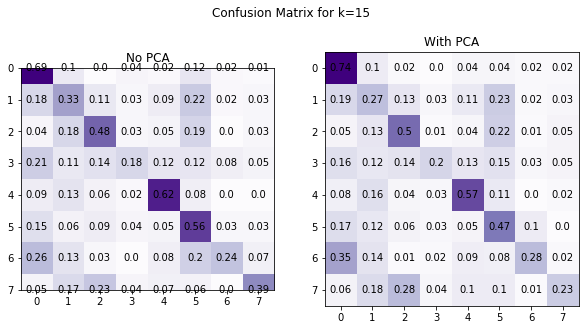

Accuracy score noPCA= 0.4405506883604506
Accuracy score PCA = 0.3967459324155194


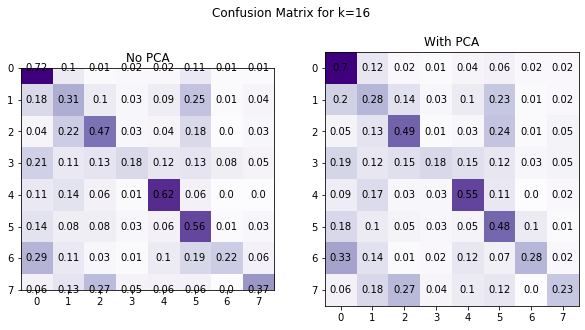

Accuracy score noPCA= 0.4530663329161452
Accuracy score PCA = 0.3967459324155194


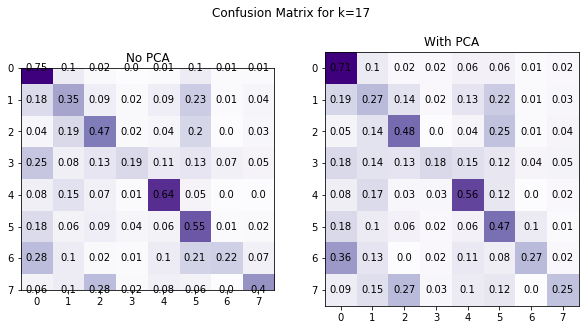

Accuracy score noPCA= 0.4430538172715895
Accuracy score PCA = 0.38923654568210264


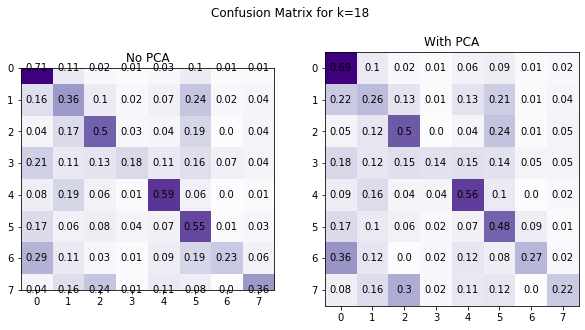

Accuracy score noPCA= 0.43679599499374216
Accuracy score PCA = 0.3904881101376721


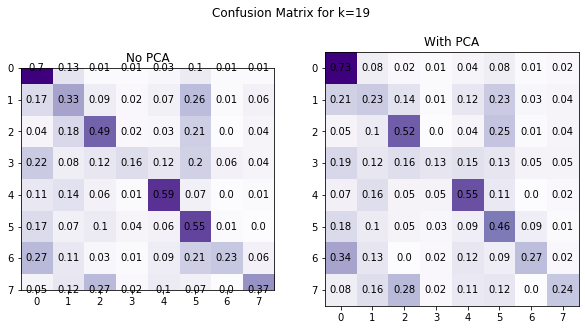

Accuracy score noPCA= 0.44180225281602004
Accuracy score PCA = 0.3854818523153942


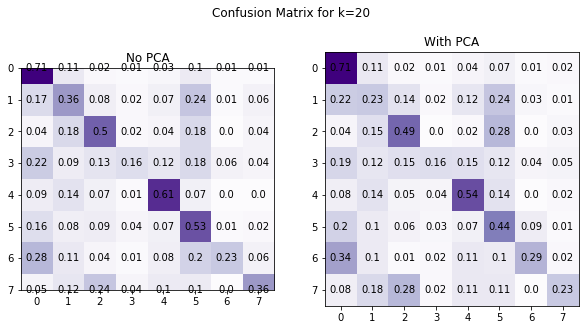

Accuracy score noPCA= 0.425531914893617
Accuracy score PCA = 0.3879849812265332


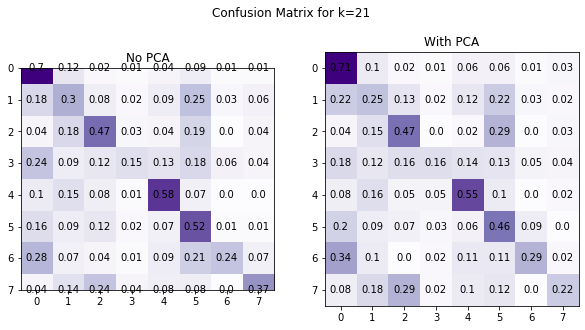

Accuracy score noPCA= 0.43929912390488113
Accuracy score PCA = 0.3904881101376721


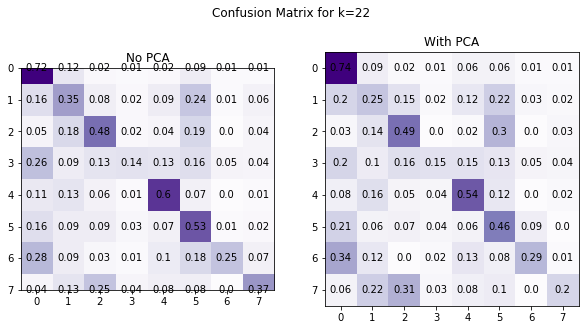

Accuracy score noPCA= 0.43429286608260326
Accuracy score PCA = 0.3979974968710889


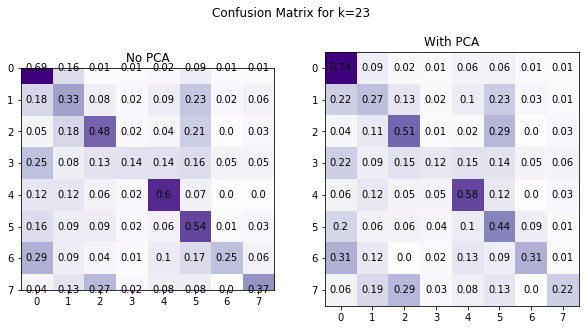

Accuracy score noPCA= 0.4380475594493116
Accuracy score PCA = 0.3904881101376721


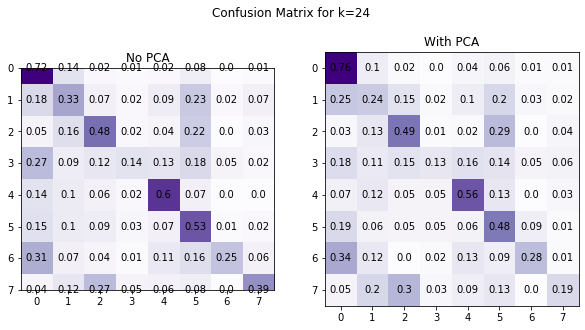

Accuracy score noPCA= 0.43929912390488113
Accuracy score PCA = 0.3967459324155194


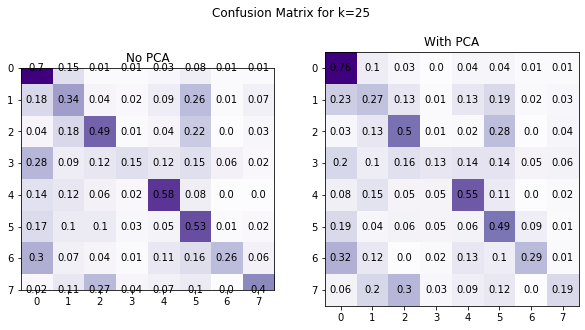

Accuracy score noPCA= 0.4267834793491865
Accuracy score PCA = 0.40425531914893614


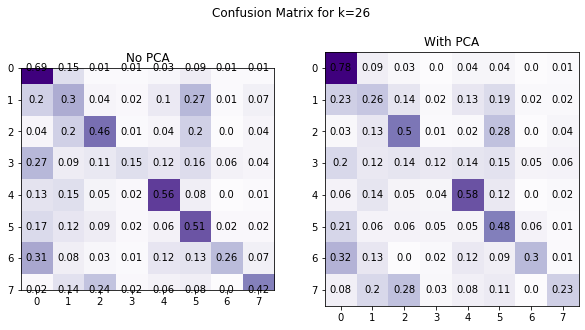

Accuracy score noPCA= 0.42177722152690866
Accuracy score PCA = 0.409261576971214


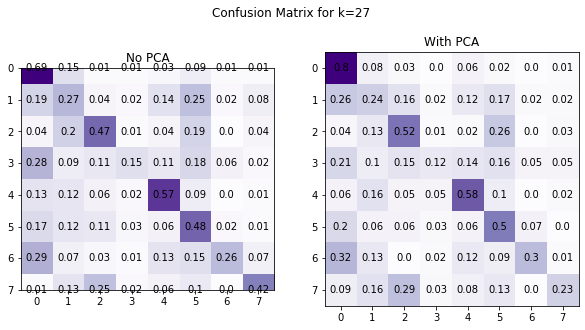

Accuracy score noPCA= 0.42052565707133915
Accuracy score PCA = 0.40425531914893614


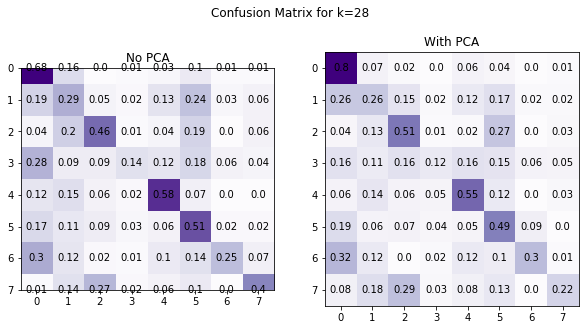

Accuracy score noPCA= 0.4292866082603254
Accuracy score PCA = 0.40550688360450565


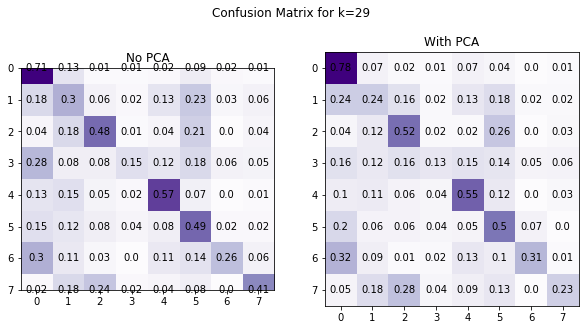

Accuracy score noPCA= 0.43679599499374216
Accuracy score PCA = 0.4067584480600751


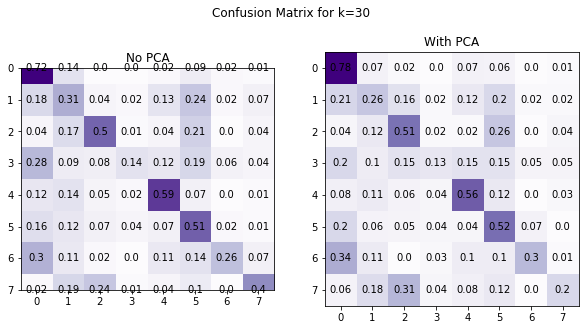

Accuracy score noPCA= 0.43429286608260326
Accuracy score PCA = 0.40175219023779724


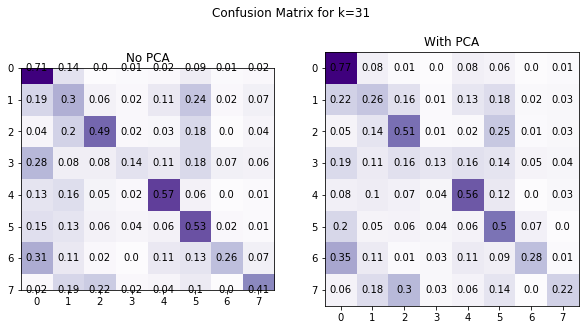

Accuracy score noPCA= 0.4330413016270338
Accuracy score PCA = 0.41051314142678347


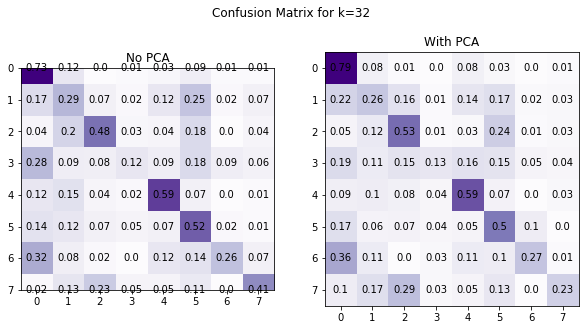

Accuracy score noPCA= 0.4267834793491865
Accuracy score PCA = 0.41051314142678347


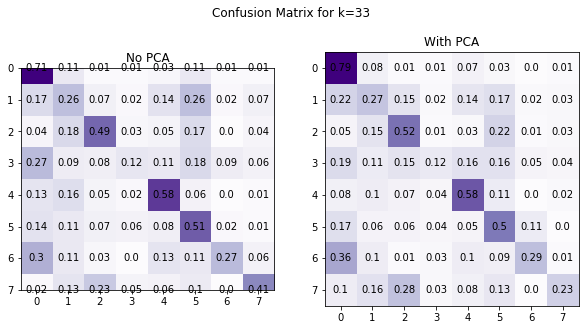

Accuracy score noPCA= 0.4330413016270338
Accuracy score PCA = 0.40550688360450565


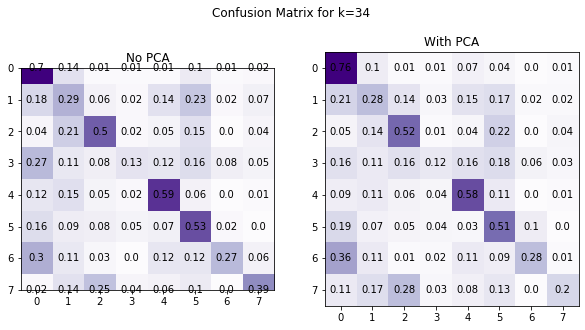

Accuracy score noPCA= 0.4292866082603254
Accuracy score PCA = 0.40425531914893614


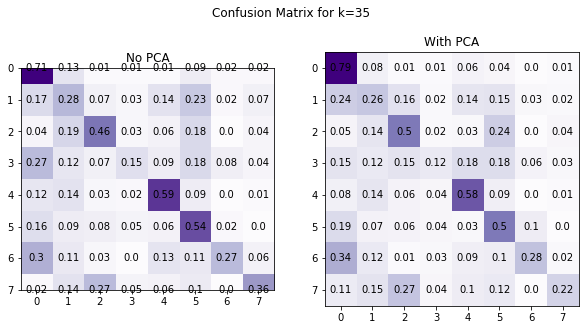

Accuracy score noPCA= 0.425531914893617
Accuracy score PCA = 0.3992490613266583


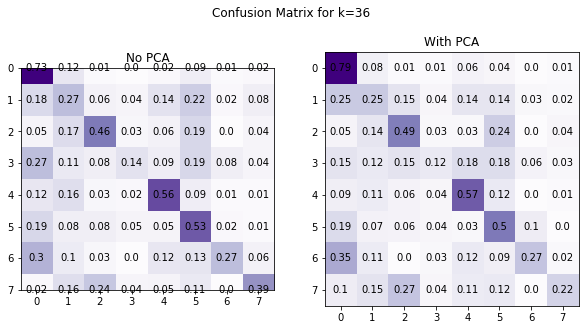

Accuracy score noPCA= 0.425531914893617
Accuracy score PCA = 0.3967459324155194


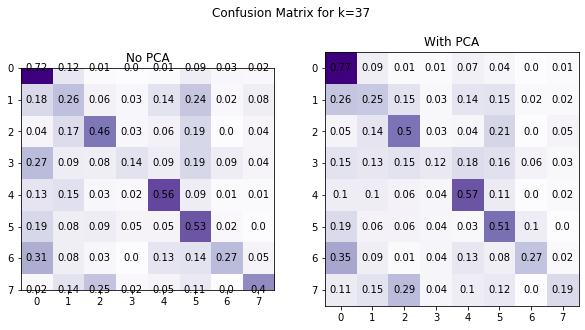

Accuracy score noPCA= 0.4292866082603254
Accuracy score PCA = 0.39424280350438046


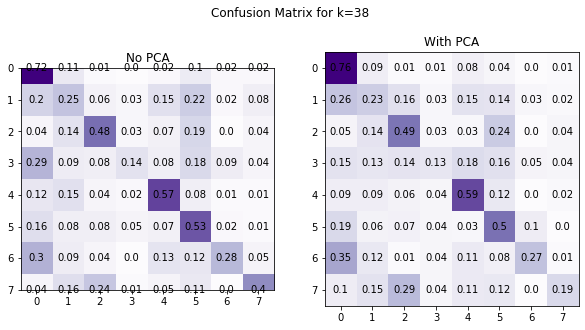

Accuracy score noPCA= 0.42177722152690866
Accuracy score PCA = 0.3904881101376721


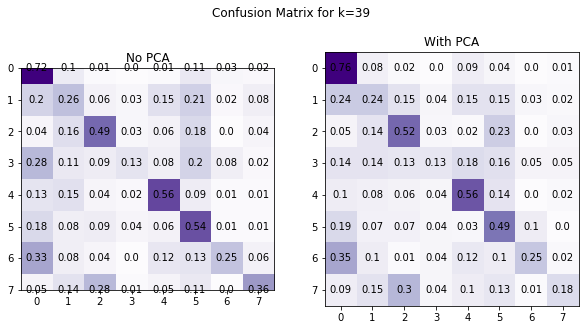

Accuracy score noPCA= 0.4192740926157697
Accuracy score PCA = 0.39173967459324155


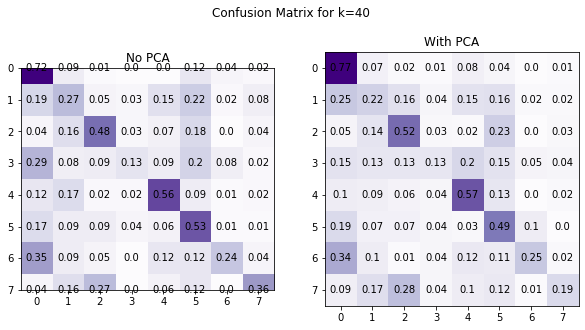

In [9]:
acc_noPCA_only = [i[0] for i in accuracy_noPCA]
acc_PCA_only = [i[0] for i in accuracy_PCA]

conf_noPCA = [i[1] for i in accuracy_noPCA]
conf_PCA = [i[1] for i in accuracy_PCA]

fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.grid()
plt.scatter(k, acc_noPCA_only, alpha = 1, s = 20, color = 'black')
plt.xticks(k)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracies on validation set using kNN, no PCA')
plt.show()

fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.grid()
plt.scatter(k, acc_noPCA_only, alpha = 1, s = 20, color = 'black', label='Without PCA')
plt.scatter(k, acc_PCA_only, alpha = 1, s = 20, color = 'red', label='With PCA')
plt.xticks(k)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracies on validation set using kNN, including PCA')
plt.legend(loc='lower right')
plt.show()

# normalize confusion matrix:
for conf in [conf_PCA, conf_noPCA]:
    for j in range(len(conf)):
        newmat = []
        for index, mat in enumerate(conf[j]):
            newmat += [[round(i/sum(mat),2) for i in mat]]

        conf[j] = newmat
    

for index, conf in enumerate(conf_noPCA):
    print(f'Accuracy score noPCA= {acc_noPCA_only[index]}')
    print(f'Accuracy score PCA = {acc_PCA_only[index]}')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f'Confusion Matrix for k={k[index]}')
    ax1.imshow(conf_noPCA[index], interpolation='nearest',cmap = 'Purples')
    ax1.set_xticks(np.array([0,1,2,3,4,5,6,7]))
    ax1.set_yticks(np.array([0,1,2,3,4,5,6,7]))
    ax2.imshow(conf_PCA[index], interpolation='nearest',cmap = 'Purples')
    ax1.set_title('No PCA')
    ax2.set_title('With PCA')
    for (j,i),label in np.ndenumerate(conf_noPCA[index]):
        ax1.text(i,j,label,ha='center',va='center', color = 'black')
    for (j,i),label in np.ndenumerate(conf_PCA[index]):
        ax2.text(i,j,label,ha='center',va='center', color = 'black')
    plt.show()



In [10]:
# test different values of component of PCA
n_comps = [i*5 for i in range(1, 51)]

all_acc_PCA = []
max_acc_PCA = []
ks = []
conf_mats = []
for n_comp in n_comps:
    pca_features = perform_PCA(n_comp, features)
    split_feat = split(pca_features)
    acc, k = train(split_feat[4], split_feat[5], split_feat[6], split_feat[7])
#     print(acc)
    all_acc = [i[0] for i in acc]
    all_conf = [i[1] for i in acc]
    max_acc = max(all_acc)
    all_acc_PCA += [all_acc]
    conf_mats += [all_conf[all_acc.index(max_acc)]]
    max_acc_PCA += [max_acc]
    ks += [all_acc.index(max_acc)]


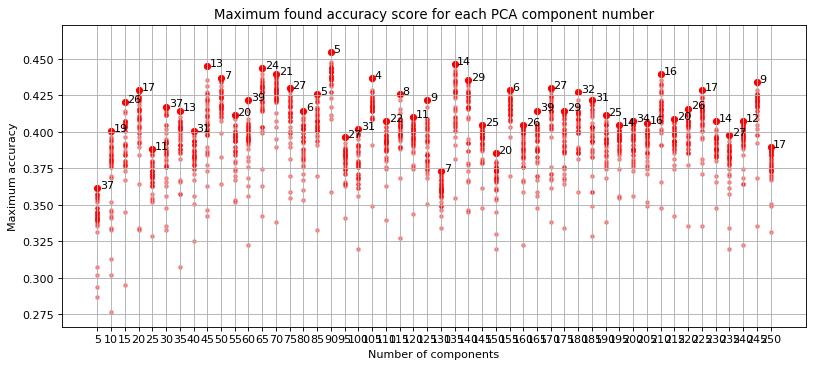

In [11]:
fig=plt.figure(figsize=(12, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(n_comps, max_acc_PCA, color='red', s=30)
for index, acc in enumerate(all_acc_PCA):
    for k in acc:
        plt.scatter(n_comps[index], k, color='red', alpha = 0.4, s=10)
plt.grid()
plt.xticks(n_comps)
plt.xlabel('Number of components')
plt.ylabel('Maximum accuracy')
plt.title('Maximum found accuracy score for each PCA component number')

for i, txt in enumerate(ks):
    plt.annotate(str(txt), (n_comps[i]+1, max_acc_PCA[i]))

plt.show()

Decision tree Classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(x_train, x_test, y_train, y_test, depth):
    tree = DecisionTreeClassifier(max_depth = depth)
    tree.fit(x_train, y_train)
    y_predicted = tree.predict(x_test)
    
    return accuracy_score(y_test, y_predicted), confusion_matrix(y_test, y_predicted)

max_depth = 30
tree_accuracies_no_PCA = [decision_tree(reg_feat_train_sm, reg_feat_val, reg_genre_train_sm, reg_genre_val, i)[0] for i in range(1, max_depth)]  
tree_accuracies_PCA = [decision_tree(reg_pca_feat_train_sm, reg_pca_feat_val, reg_pca_genre_train_sm, reg_pca_genre_val, i)[0] for i in range(1, max_depth)]
depth = [i for i in range(1, max_depth)]

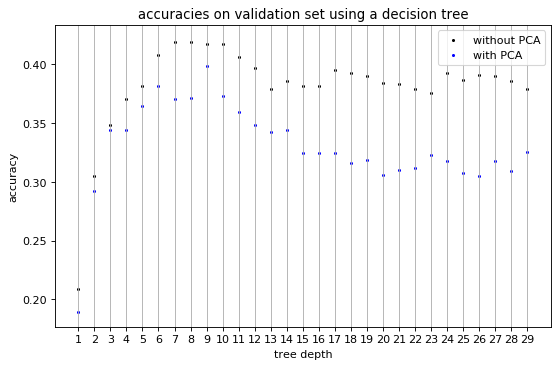

In [13]:
plt.figure(num=None, figsize=(8, 5), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(depth, tree_accuracies_no_PCA, alpha = 1, s = 3, color = 'black', label = 'without PCA')
plt.scatter(depth, tree_accuracies_PCA, alpha = 1, s = 3, color = 'blue', label = 'with PCA')
plt.grid(axis = 'x')
plt.xticks(depth)
plt.xlabel('tree depth')
plt.ylabel('accuracy')
plt.title('accuracies on validation set using a decision tree')
plt.legend()
plt.show()

Naive Bayes Classifier 

In [14]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
genre_pred = nb.fit(feat_train_sm, genre_train_sm).predict(feat_val)
print(f'Number of mislabeled points out of a total points of {len(genre_val)} :', len([i for i in range(len(genre_val)) if genre_val[i] != genre_pred[i]]))

Number of mislabeled points out of a total points of 719 : 462
